<a href="https://colab.research.google.com/github/37stu37/FFE/blob/master/sampling_PGA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
%%time 
%%capture
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes

CPU times: user 303 ms, sys: 68.5 ms, total: 371 ms
Wall time: 23.1 s


In [9]:
# Load the Drive helper and mount
from google.colab import drive
%tensorflow_version 2.x
# This will prompt for authorization.
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import glob
from math import sqrt
import os
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import numpy as np
import pandas as pd
import geopandas as gpd
import math

%matplotlib inline

In [11]:
path = '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'
!ls '/content/drive/My Drive/05_Sync/FFE/FireNetwork/00_input'

buildings_raw.cpg		   outputs_centroids_allpga_1000GMFsPERCENTILES
buildings_raw.dbf		   SA2.cpg
buildings_raw.prj		   SA2.dbf
buildings_raw_pts.cpg		   SA2.prj
buildings_raw_pts.dbf		   SA2.qpj
buildings_raw_pts.mshp		   SA2.shp
buildings_raw_pts.prj		   SA2.shx
buildings_raw_pts.shp		   source_target.csv
buildings_raw_pts.shx		   WairarapNich.cpg
buildings_raw.qpj		   WairarapNich.dbf
buildings_raw.shp		   WairarapNich.prj
buildings_raw.shx		   WairarapNich.qpj
GD_wind.csv			   WairarapNich.shp
HikWgtmax.dbf			   WairarapNich.shx
HikWgtmax.prj			   Wairau.dbf
HikWgtmax.qpj			   Wairau.prj
HikWgtmax.shp			   Wairau.qpj
HikWgtmax.shx			   Wairau.shp
HikWgtmin.dbf			   Wairau.shx
HikWgtmin.prj			   WellWHV.dbf
HikWgtmin.qpj			   WellWHV.prj
HikWgtmin.shp			   WellWHV.qpj
HikWgtmin.shx			   WellWHV.shp
outputs_centroids_allpga_1000GMFs  WellWHV.shx


In [0]:
# SA2 input data
SA2 = gpd.read_file(os.path.join(path, "SA2.shp"))
# PGA input data
PGA = gpd.read_file(os.path.join(path, "WellWHV.shp"))
# buildings data
buildings = gpd.read_file(os.path.join(path, "buildings_raw.shp"))

In [13]:
SA2.columns, PGA.columns, buildings.columns

(Index(['OBJECTID', 'SA22018_V1', 'SA22018__1', 'LAND_AREA_', 'AREA_SQ_KM',
        'Pop_Total_', 'SA2_ID', 'Shape_Leng', 'Shape_Area', 'PopDensity',
        'BldgFloor_', 'BldgFloo_1', 'NumberBldg', 'geometry'],
       dtype='object'),
 Index(['SA2', 'sid', 'lon', 'lat', 'mean', 'pone', 'ptwo', 'pthree', 'pfour',
        'pfive', 'psix', 'pseven', 'geometry'],
       dtype='object'),
 Index(['TARGET_FID', 'suburb_loc', 'Combustibl', 'SHAPE_Leng', 'SHAPE_Area',
        'AU2013Num', 'IgnProb_bl', 'RandProb', 'geometry'],
       dtype='object'))

In [37]:
SA2.geometry

0     POLYGON ((1753366.394 5441813.387, 1753328.463...
1     POLYGON ((1744852.500 5427971.793, 1744716.795...
2     POLYGON ((1750419.007 5431758.906, 1750362.620...
3     POLYGON ((1751331.976 5432513.968, 1751386.822...
4     POLYGON ((1748516.704 5428769.002, 1748516.708...
                            ...                        
71    POLYGON ((1753314.360 5425868.100, 1753324.786...
72    POLYGON ((1749820.120 5423262.735, 1749790.522...
73    POLYGON ((1751454.143 5424576.656, 1751437.292...
74    POLYGON ((1753062.244 5423610.494, 1753054.409...
75    POLYGON ((1753205.850 5424247.635, 1753152.246...
Name: geometry, Length: 76, dtype: geometry

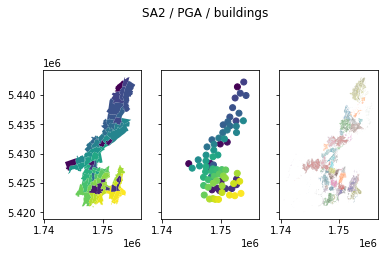

In [15]:
#plot
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True)
fig.suptitle('SA2 / PGA / buildings')
SA2.plot(ax=ax1, column='SA2_ID')
PGA.plot(ax=ax2, column='SA2')
buildings.plot(ax=ax3, column='suburb_loc')

In [0]:
def Ignition_Probability(data1, data2, building_data):
  data = data1.merge(data2, how='left', left_on='SA2_ID', right_on='SA2')
  data['SA_IgnPrb'] = 1/(np.exp(-1*(-6.755+8.463+data['mean']+0.0000984+data['PopDensity']+0.001523+data['BldgFloo_1'])))
  data['IgnProb_bl'] = 1 - np.power(1-data['SA_IgnPrb'], +1/data['NumberBldg'])
  data.drop('geometry_y', axis=1, inplace=True)
  data.rename(columns={'geometry_x': 'geometry'}, inplace=True)
  crs = {'init': 'EPSG:2193'}
  data_gdf = gpd.GeoDataFrame(data)
  buildings_with_ignition = gpd.sjoin(building_data, data_gdf, how='inner', op='within')
  buildings_with_ignition = buildings_with_ignition[['TARGET_FID', 'suburb_loc', 'Combustibl', 'SHAPE_Leng', 'SHAPE_Area',
       'AU2013Num', 'IgnProb_bl_left', 'RandProb', 'geometry']]
  buildings_with_ignition.rename(columns={'IgnProb_bl_left': 'IgnProb_bl'}, inplace=True)
  return buildings_with_ignition

In [58]:
buildings_Ign = Ignition_Probability(SA2, PGA, buildings)

/usr/local/lib/python3.6/dist-packages/geopandas/tools/sjoin.py:62: UserWarning: CRS of frames being joined does not match!(epsg:2193 != None)
  "(%s != %s)" % (left_df.crs, right_df.crs)


In [65]:
buildings_Ign.columns

Index(['TARGET_FID', 'suburb_loc', 'Combustibl', 'SHAPE_Leng', 'SHAPE_Area',
       'AU2013Num', 'IgnProb_bl', 'RandProb', 'geometry'],
      dtype='object')

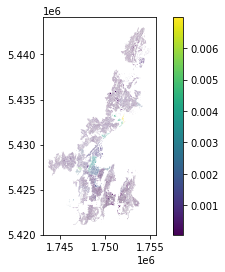

In [64]:
buildings_Ign.plot(column='IgnProb_bl', legend=True)

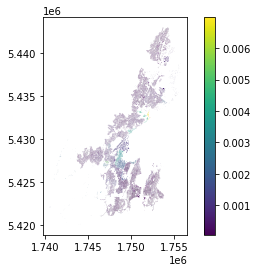

In [66]:
buildings.plot(column='IgnProb_bl', legend=True)